# Spatial Mapping

## Table of Contents

1. [Introduction](#1.-Introduction)
2. [Convert Model Predictions to Spatial Data](#2.-Convert-Model-Predictions-to-Spatial-Data)
3. [Validate the Suitability Maps](#3.-Validate-the-Suitability-Maps)

## 1. Introduction

The final stage of species distribution modelling involves translating model outputs into spatially explicit predictions for visualization and analysis in Geographic Information Systems (GIS). This step is crucial for identifying suitable habitats, informing conservation planning, and integrating results into decision-making frameworks.

Species distribution models (SDMs) generate probability estimates of species presence based on environmental predictors. These probabilities must be converted into spatially explicit rasters or vector layers that align with the study area’s geographic coordinates. The transition from tabular predictions to spatial datasets ensures that results can be integrated with other environmental data, such as land cover, habitat connectivity, and conservation priorities.

The goal is to predict species suitability across a continuous landscape using environmental predictors. This is typically achieved by applying trained models to these predictors to generate continuous suitability maps.

### Interpolation vs. Model Application:

1. **Model Application**: After training the models (e.g., Random Forest, XGBoost, MaxEnt) using occurrence data and environmental predictors, these trained models can be applied to the same set of predictors across the entire study area. This process generates continuous suitability values for each location, resulting in a comprehensive suitability map.

2. **Interpolation:** Interpolation methods, such as kriging, estimate values at unsampled locations based on the spatial configuration of sampled points. While interpolation can be useful in certain contexts, it doesn't leverage the relationship between species occurrences and environmental predictors as effectively as direct model application.

## 2. Create Suitability Maps

To create continuous suitability maps we will:
1. **Prepare Environmental Predictors**: Ensure all environmental predictor rasters are aligned (same resolution, extent, and coordinate system).
2. **Apply Trained Models**: Use the trained ensemble model to predict suitability values across the entire study area by applying it to the predictor rasters.
3. **Generate Suitability Maps**: The output will be continuous suitability maps indicating the predicted probability of species presence for each location.

### **Load Final Suitability Predictions**

In [61]:
import os
import pandas as pd
import geopandas as gpd

# Define paths
prediction_dir = r"C:\GIS_Course\MScThesis-MaviSantarelli\results\Models\Ensemble_Predictions\Final_Binary"
species_list = ["Bufo bufo", "Rana temporaria", "Lissotriton helveticus"]

# Load prediction files
predictions = {}
for species in species_list:
    file_path = os.path.join(prediction_dir, f"{species}_Final_Binary_Predictions.csv")
    if os.path.exists(file_path):
        predictions[species] = pd.read_csv(file_path)
        print(f"✅ Loaded predictions for {species}")
    else:
        print(f"⚠️ Missing predictions for {species}")


✅ Loaded predictions for Bufo bufo
✅ Loaded predictions for Rana temporaria
✅ Loaded predictions for Lissotriton helveticus


### **Stack Predictors into a Multi-Band Raster**

### Check Raster Shapes Before Stacking

In [3]:
import rasterio

# Define predictor raster file paths
predictor_files = [
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Building_Density_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/DistWater_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/NOx_Stand_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/RGS_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Runoff_Coefficient_Standardised_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Slope_Proj_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/SoilMoisture_32bit_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Traffic_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Wood_Resample_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Grass_Stand.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/NDVI_median.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/NDVI_StDev.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/VegHeight.tif"
]

# Check raster shapes
for file in predictor_files:
    with rasterio.open(file) as src:
        print(f"{file}: {src.shape}, Resolution: {src.res}, CRS: {src.crs}")


C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Building_Density_Reversed.tif: (5971, 6369), Resolution: (30.0, 30.0), CRS: EPSG:27700
C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/DistWater_Reversed.tif: (5971, 6369), Resolution: (30.0, 30.0), CRS: EPSG:27700
C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/NOx_Stand_Reversed.tif: (5971, 6369), Resolution: (30.0, 30.0), CRS: EPSG:27700
C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/RGS_Reversed.tif: (5971, 6369), Resolution: (30.0, 30.0), CRS: EPSG:27700
C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Runoff_Coefficient_Standardised_Reversed.tif: (5970, 6369), Resolution: (30.0, 30.0), CRS: EPSG:27700
C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Slope_Proj_Reversed.tif: (5971, 6369), Resolution: (30.0, 30.0), CRS: EPSG:27700
C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/SoilMo

### Reproject and Resample to Match a Reference Raster

In [4]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os

# Choose a reference raster (first predictor)
reference_raster = predictor_files[0]

# Define output directory for resampled rasters
output_dir = "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Resampled"
os.makedirs(output_dir, exist_ok=True)

# Open reference raster
with rasterio.open(reference_raster) as ref_src:
    ref_transform = ref_src.transform
    ref_width = ref_src.width
    ref_height = ref_src.height
    ref_crs = ref_src.crs

# Resample and reproject other rasters to match reference
for file in predictor_files:
    output_file = os.path.join(output_dir, os.path.basename(file))

    with rasterio.open(file) as src:
        if (src.shape != (ref_height, ref_width)) or (src.crs != ref_crs):
            print(f"🔄 Resampling {file}...")

            # Calculate new transform and dimensions
            transform, width, height = calculate_default_transform(
                src.crs, ref_crs, src.width, src.height, *src.bounds
            )

            # Update metadata
            new_meta = src.meta.copy()
            new_meta.update({
                "crs": ref_crs,
                "transform": transform,
                "width": ref_width,
                "height": ref_height
            })

            # Create resampled raster
            with rasterio.open(output_file, "w", **new_meta) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=ref_crs,
                        resampling=Resampling.bilinear  # Use bilinear resampling
                    )

            print(f"✅ Resampled and saved: {output_file}")
        else:
            print(f"✅ {file} already matches reference raster.")

print("\n🚀 Resampling complete! Use these resampled rasters for stacking.")


✅ C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Building_Density_Reversed.tif already matches reference raster.
✅ C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/DistWater_Reversed.tif already matches reference raster.
✅ C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/NOx_Stand_Reversed.tif already matches reference raster.
✅ C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/RGS_Reversed.tif already matches reference raster.
🔄 Resampling C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Runoff_Coefficient_Standardised_Reversed.tif...
✅ Resampled and saved: C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Resampled\Runoff_Coefficient_Standardised_Reversed.tif
✅ C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Slope_Proj_Reversed.tif already matches reference raster.
🔄 Resampling C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/SoilMo

### Create a List of the Correct File Paths

In [6]:
import os

# Define original predictor file paths
original_predictor_files = [
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Building_Density_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/DistWater_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/NOx_Stand_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/RGS_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Runoff_Coefficient_Standardised_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Slope_Proj_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/SoilMoisture_32bit_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Traffic_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Wood_Resample_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Grass_Stand.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/NDVI_median.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/NDVI_StDev.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/VegHeight.tif"
]

# Define resampled directory
resampled_dir = "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Resampled"

# Generate final paths: use resampled files if they exist, otherwise use original
final_predictor_files = []
for file in original_predictor_files:
    resampled_path = os.path.join(resampled_dir, os.path.basename(file))
    
    if os.path.exists(resampled_path):  # Use resampled version if available
        final_predictor_files.append(resampled_path)
    else:  # Use original file
        final_predictor_files.append(file)

# Print final list to check
for file in final_predictor_files:
    print(f"✅ Using: {file}")


✅ Using: C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Building_Density_Reversed.tif
✅ Using: C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/DistWater_Reversed.tif
✅ Using: C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/NOx_Stand_Reversed.tif
✅ Using: C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/RGS_Reversed.tif
✅ Using: C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Resampled\Runoff_Coefficient_Standardised_Reversed.tif
✅ Using: C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Slope_Proj_Reversed.tif
✅ Using: C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Resampled\SoilMoisture_32bit_Reversed.tif
✅ Using: C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Traffic_Reversed.tif
✅ Using: C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Wood_Resample_Reversed.tif
✅ Using: C:/GIS_Course/MScThesis-MaviSantarelli/data/Pred

### Stack Resampled Rasters

In [11]:
import rasterio
import numpy as np

# Read and stack all predictors
stacked_data = []
meta = None

for i, file in enumerate(final_predictor_files):
    with rasterio.open(file) as src:
        if meta is None:
            meta = src.meta.copy()  # Save metadata from first raster
        data = src.read(1)  # Read the first band
        stacked_data.append(data)

# Convert to numpy array
stacked_array = np.stack(stacked_data, axis=0)

# Check stacked raster shape
print(f"✅ Stacked raster shape: {stacked_array.shape}")

# Save the stacked raster
meta.update(count=len(stacked_data), dtype=rasterio.float32)

with rasterio.open(stacked_raster_path, "w", **meta) as dst:
    dst.write(stacked_array.astype(rasterio.float32))

print(f"✅ Stacked raster saved at: {stacked_raster_path}")


✅ Stacked raster shape: (13, 5971, 6369)
✅ Stacked raster saved at: C:\GIS_Course\MScThesis-MaviSantarelli\data\Predictors\Stacked_Predictors.tif


### **Convert Raster to Model Input Format**

In [8]:
import pandas as pd

# Reshape raster stack into a 2D table (num_pixels, num_predictors)
num_bands, height, width = stacked_array.shape
reshaped_array = stacked_array.reshape(num_bands, -1).T  # Transpose to (num_pixels, num_predictors)

# Convert to DataFrame
predictor_df = pd.DataFrame(reshaped_array, columns=[f"Predictor_{i+1}" for i in range(num_bands)])

# Check for missing values
print(f"✅ Predictor DataFrame Shape: {predictor_df.shape}")
print(f"🔍 Missing Values:\n{predictor_df.isnull().sum()}")

# Drop rows with NaN values (if any)
predictor_df = predictor_df.dropna().reset_index(drop=True)
print(f"✅ Cleaned Predictor DataFrame Shape: {predictor_df.shape}")


✅ Predictor DataFrame Shape: (38029299, 13)
🔍 Missing Values:
Predictor_1     0
Predictor_2     0
Predictor_3     0
Predictor_4     0
Predictor_5     0
Predictor_6     0
Predictor_7     0
Predictor_8     0
Predictor_9     0
Predictor_10    0
Predictor_11    0
Predictor_12    0
Predictor_13    0
dtype: int64
✅ Cleaned Predictor DataFrame Shape: (38029299, 13)


### **Load the Ensemble Model**

In [82]:
import joblib
import os

# Define paths to saved models
model_dir = r"C:\GIS_Course\MScThesis-MaviSantarelli\results\Models\Weighted_Ensemble"
species_list = ["Bufo bufo", "Rana temporaria", "Lissotriton helveticus"]

# Dictionary to store loaded models
loaded_models = {}

# Load models
for species in species_list:
    model_path = os.path.join(model_dir, f"{species}_Final_Ensemble_Model.pkl")
    
    if os.path.exists(model_path):
        loaded_models[species] = joblib.load(model_path)
        print(f"✅ Loaded model for {species}")
    else:
        print(f"⚠️ Model missing for {species}: {model_path}")


✅ Loaded model for Bufo bufo
✅ Loaded model for Rana temporaria
✅ Loaded model for Lissotriton helveticus


### **Predict Suitability for Each Pixel**

In [74]:
# Fix column names by mapping resampled features to original names
predictor_df.columns = [
    col.replace("Resampled\\", "Input/").replace("Resampled/", "Input/")
    for col in predictor_df.columns
]

# Verify if the renaming worked
print("✅ Updated predictor DataFrame column names:\n", predictor_df.columns)


✅ Updated predictor DataFrame column names:
 Index(['C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Building_Density_Reversed.tif',
       'C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/DistWater_Reversed.tif',
       'C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/NOx_Stand_Reversed.tif',
       'C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/RGS_Reversed.tif',
       'C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Runoff_Coefficient_Standardised_Reversed.tif',
       'C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Slope_Proj_Reversed.tif',
       'C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/SoilMoisture_32bit_Reversed.tif',
       'C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Traffic_Reversed.tif',
       'C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Wood_Resample_Reversed.tif',
       'C:/

In [76]:
# Ensure all predictors match what the model expects
corrected_columns = []
for col in predictor_df.columns:
    if "Runoff_Coefficient_Standardised_Reversed.tif" in col:
        corrected_columns.append("C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Runoff_Coefficient_Standardised_Reversed.tif")
    elif "SoilMoisture_32bit_Reversed.tif" in col:
        corrected_columns.append("C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/SoilMoisture_32bit_Reversed.tif")
    else:
        corrected_columns.append(col)

# Update predictor DataFrame column names
predictor_df.columns = corrected_columns

# Print updated columns to confirm
print("✅ Final Predictor DataFrame column names:\n", predictor_df.columns)


✅ Final Predictor DataFrame column names:
 Index(['C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Building_Density_Reversed.tif',
       'C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/DistWater_Reversed.tif',
       'C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/NOx_Stand_Reversed.tif',
       'C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/RGS_Reversed.tif',
       'C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Runoff_Coefficient_Standardised_Reversed.tif',
       'C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Slope_Proj_Reversed.tif',
       'C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/SoilMoisture_32bit_Reversed.tif',
       'C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Traffic_Reversed.tif',
       'C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Wood_Resample_Reversed.t

In [83]:
# Dictionary to store suitability predictions
suitability_predictions = {}

for species, model in loaded_models.items():
    print(f"🔍 Predicting habitat suitability for {species}...")

    # ✅ Corrected: Get probability predictions (0 to 1) instead of binary (0/1)
    suitability_predictions[species] = model.predict_proba(predictor_df)[:, 1]  

    print(f"✅ Predictions complete for {species}")



🔍 Predicting habitat suitability for Bufo bufo...
✅ Predictions complete for Bufo bufo
🔍 Predicting habitat suitability for Rana temporaria...
✅ Predictions complete for Rana temporaria
🔍 Predicting habitat suitability for Lissotriton helveticus...
✅ Predictions complete for Lissotriton helveticus


### **Reshape Predictions to Raster Format**

In [84]:
import numpy as np
import rasterio

# Define output directory for suitability maps
suitability_map_dir = r"C:\GIS_Course\MScThesis-MaviSantarelli\results\Suitability_Maps"
os.makedirs(suitability_map_dir, exist_ok=True)

# Get raster metadata from stacked raster
with rasterio.open(r"C:\GIS_Course\MScThesis-MaviSantarelli\data\Predictors\Stacked_Predictors.tif") as src:
    meta = src.meta.copy()

# Update metadata to store a single band (suitability predictions)
meta.update(count=1, dtype=rasterio.float32)

# Reshape predictions and save as raster
for species, predictions in suitability_predictions.items():
    print(f"🗺️ Saving suitability map for {species}...")

    # Reshape 1D predictions back to raster dimensions
    suitability_raster = predictions.reshape(meta['height'], meta['width'])

    # Define output file path
    output_path = os.path.join(suitability_map_dir, f"{species}_Suitability_Map.tif")

    # Save raster
    with rasterio.open(output_path, "w", **meta) as dst:
        dst.write(suitability_raster.astype(rasterio.float32), 1)

    print(f"✅ Suitability map saved: {output_path}")

print("\n🚀 Suitability maps ready for visualization!")


🗺️ Saving suitability map for Bufo bufo...
✅ Suitability map saved: C:\GIS_Course\MScThesis-MaviSantarelli\results\Suitability_Maps\Bufo bufo_Suitability_Map.tif
🗺️ Saving suitability map for Rana temporaria...
✅ Suitability map saved: C:\GIS_Course\MScThesis-MaviSantarelli\results\Suitability_Maps\Rana temporaria_Suitability_Map.tif
🗺️ Saving suitability map for Lissotriton helveticus...
✅ Suitability map saved: C:\GIS_Course\MScThesis-MaviSantarelli\results\Suitability_Maps\Lissotriton helveticus_Suitability_Map.tif

🚀 Suitability maps ready for visualization!


## 3. Validate the Suitability Maps

### **Load & Check Suitability Maps**

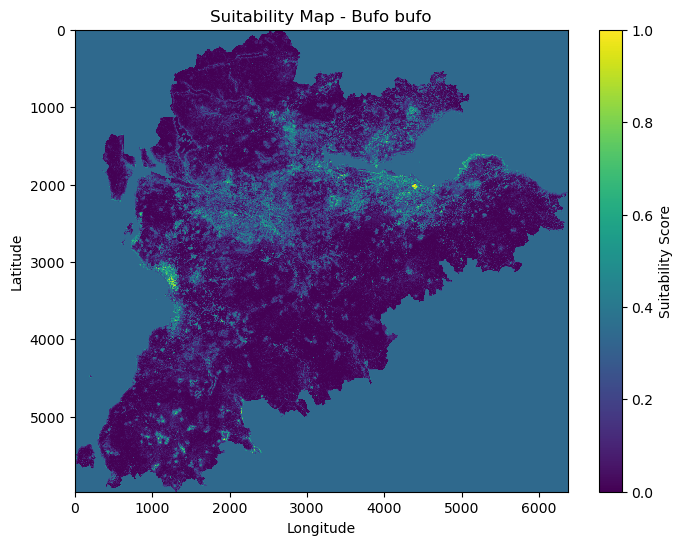

<Figure size 640x480 with 0 Axes>

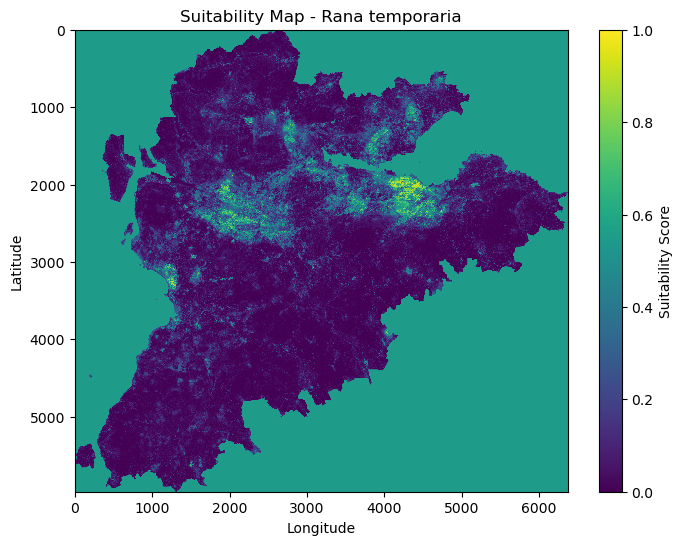

<Figure size 640x480 with 0 Axes>

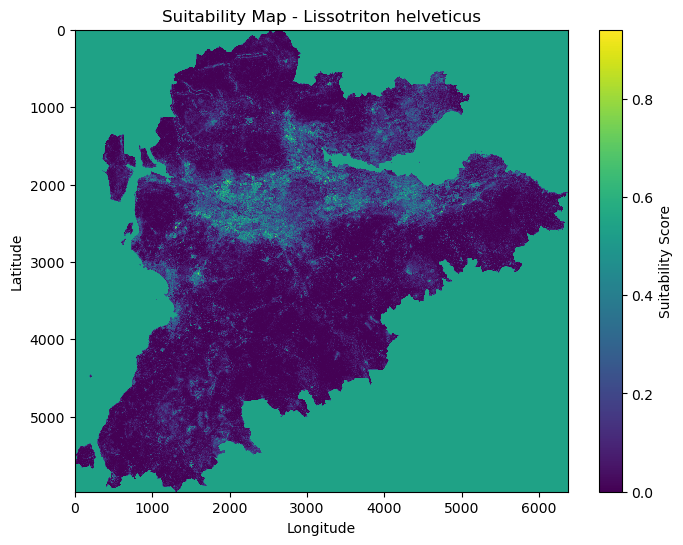

<Figure size 640x480 with 0 Axes>

In [98]:
import matplotlib.pyplot as plt

# Load and display the suitability maps
for species in suitability_predictions.keys():
    map_path = os.path.join(suitability_map_dir, f"{species}_Suitability_Map.tif")

    with rasterio.open(map_path) as src:
        data = src.read(1)  # Read first band

    plt.figure(figsize=(8, 6))
    plt.imshow(data, cmap="viridis", interpolation="nearest")
    plt.colorbar(label="Suitability Score")
    plt.title(f"Suitability Map - {species}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

    # Save the plot as a PNG file
    output_path = os.path.join(suitability_map_dir, f"{species}_Suitability_Map.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    
    plt.show()


### **Save as GeoTIFF**

In [86]:
import rasterio

# Define output directory
output_dir = r"C:\GIS_Course\MScThesis-MaviSantarelli\results\Suitability_Maps"

# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)

# Save each species' suitability map
for species, predictions in suitability_predictions.items():
    output_path = os.path.join(output_dir, f"{species}_Suitability.tif")

    # Reshape back into raster dimensions
    suitability_raster = predictions.reshape(height, width)

    # Save as GeoTIFF
    with rasterio.open(
        output_path, "w",
        driver="GTiff",
        height=height, width=width,
        count=1, dtype=rasterio.float32,
        crs=meta["crs"], transform=meta["transform"]
    ) as dst:
        dst.write(suitability_raster.astype(rasterio.float32), 1)

    print(f"✅ Saved suitability map: {output_path}")


✅ Saved suitability map: C:\GIS_Course\MScThesis-MaviSantarelli\results\Suitability_Maps\Bufo bufo_Suitability.tif
✅ Saved suitability map: C:\GIS_Course\MScThesis-MaviSantarelli\results\Suitability_Maps\Rana temporaria_Suitability.tif
✅ Saved suitability map: C:\GIS_Course\MScThesis-MaviSantarelli\results\Suitability_Maps\Lissotriton helveticus_Suitability.tif


### **Check Metadata**

In [87]:
import rasterio

for species in suitability_predictions.keys():
    file_path = os.path.join(output_dir, f"{species}_Suitability.tif")

    with rasterio.open(file_path) as src:
        print(f"\n🔍 Checking {species} raster...")
        print(f"  CRS: {src.crs}")
        print(f"  Resolution: {src.res}")
        print(f"  Shape: {src.shape}")
        print(f"  Min: {src.read(1).min()}, Max: {src.read(1).max()}")



🔍 Checking Bufo bufo raster...
  CRS: EPSG:27700
  Resolution: (30.0, 30.0)
  Shape: (5971, 6369)
  Min: 0.0, Max: 1.0

🔍 Checking Rana temporaria raster...
  CRS: EPSG:27700
  Resolution: (30.0, 30.0)
  Shape: (5971, 6369)
  Min: 0.0, Max: 1.0

🔍 Checking Lissotriton helveticus raster...
  CRS: EPSG:27700
  Resolution: (30.0, 30.0)
  Shape: (5971, 6369)
  Min: 0.0, Max: 0.9399999976158142


### **Compare Predictions to Presence Data**
### Load Presence Points

In [89]:
import geopandas as gpd
import rasterio
import rasterio.sample
import numpy as np
import os

# Define presence points directory
presence_dir = r"/GIS_Course/MScThesis-MaviSantarelli/data/OccurrenceData/OccurrenceDataperSpecies"

# Define species shapefile paths (Bufo bufo example)
species_shapefiles = {
    "Bufo bufo": os.path.join(presence_dir, "Bufo_bufo.shp"),
    "Rana temporaria": os.path.join(presence_dir, "Rana_temporaria.shp"),
    "Lissotriton helveticus": os.path.join(presence_dir, "Lissotriton_helveticus.shp"),
}

# Load presence points for each species
presence_data = {}
for species, shp_path in species_shapefiles.items():
    presence_data[species] = gpd.read_file(shp_path)
    print(f"✅ Loaded {species} presence points ({len(presence_data[species])} records).")


✅ Loaded Bufo bufo presence points (716 records).
✅ Loaded Rana temporaria presence points (1110 records).
✅ Loaded Lissotriton helveticus presence points (337 records).


### Extract Suitability Values from Raster Maps


In [95]:
import os
import pandas as pd
import numpy as np
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# Define directory where suitability maps are stored
suitability_dir = r"C:\GIS_Course\MScThesis-MaviSantarelli\results\Suitability_Maps"

# List to store extracted data
validation_results = []

# Extract suitability values for each species
for species, gdf in presence_data.items():
    raster_path = os.path.join(suitability_dir, f"{species}_Suitability.tif")

    with rasterio.open(raster_path) as src:
        # Ensure CRS matches
        gdf = gdf.to_crs(src.crs)

        # Sample raster at presence locations
        coords = [(x, y) for x, y in zip(gdf.geometry.x, gdf.geometry.y)]
        values = np.array([v[0] for v in src.sample(coords)])

    # Store results in long format
    for val in values:
        validation_results.append({"Species": species, "Suitability": val})

    print(f"✅ Extracted suitability values for {species} presence points.")

# Convert results to DataFrame
validation_df = pd.DataFrame(validation_results)

# ✅ Display DataFrame
validation_df.head()

✅ Extracted suitability values for Bufo bufo presence points.
✅ Extracted suitability values for Rana temporaria presence points.
✅ Extracted suitability values for Lissotriton helveticus presence points.


,Species,Suitability
0,Bufo bufo,0.87
1,Bufo bufo,0.62
2,Bufo bufo,0.96
3,Bufo bufo,0.66
4,Bufo bufo,0.76


### Visualise Suitability Distributions

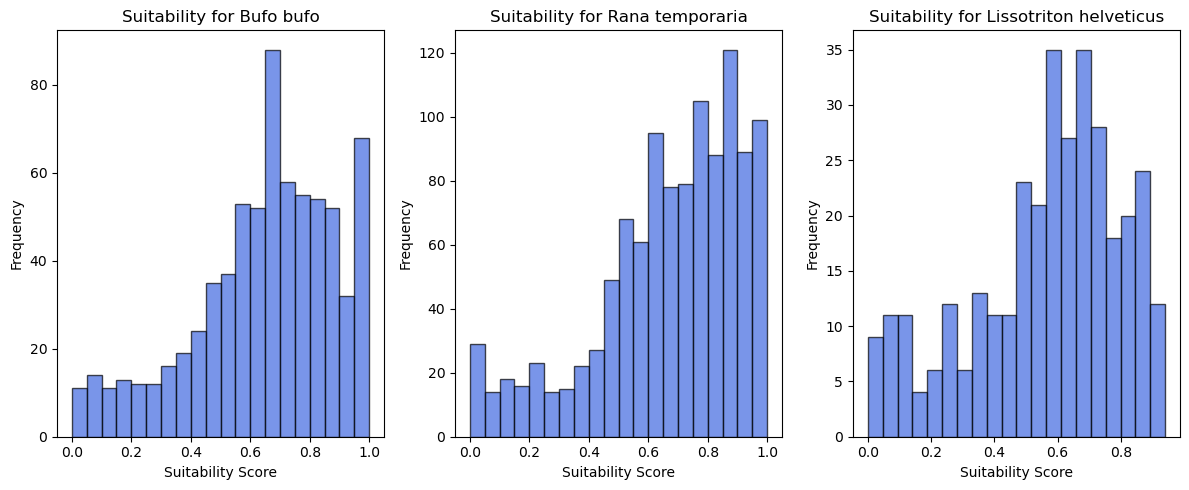

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert list to DataFrame (if not already done)
validation_df = pd.DataFrame(validation_results)

# 📊 **Histograms for Suitability Scores per Species**
plt.figure(figsize=(12, 5))

species_list = validation_df["Species"].unique()
for i, species in enumerate(species_list):
    plt.subplot(1, len(species_list), i + 1)
    plt.hist(validation_df[validation_df["Species"] == species]["Suitability"], 
             bins=20, alpha=0.7, color="royalblue", edgecolor="black")
    plt.title(f"Suitability for {species}")
    plt.xlabel("Suitability Score")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


### Create Folium Maps

In [1]:
import folium
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling, transform_bounds
import os
from branca.colormap import LinearColormap
import numpy as np
import time
from matplotlib.colors import to_rgba

# Directory containing the suitability maps
suitability_map_dir = r"C:\GIS_Course\MScThesis-MaviSantarelli\results\Suitability_Maps"

# List of species for which you have suitability maps
species_list = ['Bufo_bufo', 'Rana_temporaria', 'Lissotriton_helveticus']

# Function to convert hex color to RGBA tuple
def hex_to_rgba(hex_color):
    rgba_float = to_rgba(hex_color)
    return tuple(int(255 * c) for c in rgba_float)

# Function to reproject raster to EPSG:4326 (WGS84)
def reproject_to_wgs84(src):
    dst_crs = 'EPSG:4326'  # Folium expects WGS84
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    dest = np.empty((src.count, height, width), dtype=src.dtypes[0])

    for i in range(1, src.count + 1):
        reproject(
            source=rasterio.band(src, i),
            destination=dest[i - 1],
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear)  # Bilinear resampling for better alignment

    return dest, transform, width, height

# Function to create folium maps
def create_folium_map(species, map_path):
    print(f"Processing {species}...")
    start_time = time.time()

    with rasterio.open(map_path) as src:
        print(f"  - CRS: {src.crs}")  # Check the CRS

        # Reproject to WGS84 if not already
        if src.crs.to_string() != 'EPSG:4326':
            print("  - Reprojecting raster to WGS84...")
            data, transform, width, height = reproject_to_wgs84(src)
            bounds = transform_bounds(src.crs, 'EPSG:4326', *src.bounds)  # Accurate bounds after reprojection
        else:
            data = src.read(1)
            transform = src.transform
            bounds = src.bounds

        data = data[0] if data.ndim == 3 else data  # Handle multi-band data
        data[data == src.nodata] = np.nan  # Replace NoData values with NaN
        print(f"  - Data loaded: {data.shape}")

        # Normalize data for color mapping
        min_val, max_val = np.nanmin(data), np.nanmax(data)
        colormap = LinearColormap(['#440154', '#3b528b', '#21918c', '#5ec962', '#fde725'], vmin=min_val, vmax=max_val)
        print(f"  - Normalized data between {min_val:.2f} and {max_val:.2f}")

        # Apply colormap and convert hex to RGBA
        norm_data = (data - min_val) / (max_val - min_val)
        norm_data = np.nan_to_num(norm_data)

        # Convert normalized data to RGBA format
        colored_data = np.empty((*norm_data.shape, 4), dtype=np.uint8)
        for i in range(norm_data.shape[0]):
            for j in range(norm_data.shape[1]):
                hex_color = colormap(norm_data[i, j])  # Get hex color
                rgba = hex_to_rgba(hex_color)  # Convert hex to RGBA
                colored_data[i, j] = rgba

        # Use accurate bounds from transform_bounds for folium overlay
        folium_bounds = [[bounds[1], bounds[0]], [bounds[3], bounds[2]]]  # [[south, west], [north, east]]

        # Create the folium map centered on the raster bounds
        m = folium.Map(location=[(folium_bounds[0][0] + folium_bounds[1][0]) / 2, 
                                 (folium_bounds[0][1] + folium_bounds[1][1]) / 2], zoom_start=10)

        # Add the raster layer to the map
        folium.raster_layers.ImageOverlay(
            image=colored_data,
            bounds=folium_bounds,
            opacity=0.6
        ).add_to(m)
        print("  - Raster overlay added to map")

        # Add color legend
        colormap.caption = f'Suitability Score for {species}'
        colormap.add_to(m)

        # Save map as HTML
        map_output_path = os.path.join(suitability_map_dir, f"{species}_Suitability_Map.html")
        m.save(map_output_path)
        print(f"  - Map saved for {species} at {map_output_path}")

    end_time = time.time()
    print(f"Completed {species} in {end_time - start_time:.2f} seconds.\n")

# Create and save maps for each species
for species in species_list:
    map_path = os.path.join(suitability_map_dir, f"{species}_Suitability_Map.tif")
    create_folium_map(species, map_path)

Processing Bufo_bufo...
  - CRS: EPSG:27700
  - Reprojecting raster to WGS84...
  - Data loaded: (4141, 7798)
  - Normalized data between 0.00 and 1.00
  - Raster overlay added to map
  - Map saved for Bufo_bufo at C:\GIS_Course\MScThesis-MaviSantarelli\results\Suitability_Maps\Bufo_bufo_Suitability_Map.html
Completed Bufo_bufo in 273.81 seconds.

Processing Rana_temporaria...
  - CRS: EPSG:27700
  - Reprojecting raster to WGS84...
  - Data loaded: (4141, 7798)
  - Normalized data between 0.00 and 0.99
  - Raster overlay added to map
  - Map saved for Rana_temporaria at C:\GIS_Course\MScThesis-MaviSantarelli\results\Suitability_Maps\Rana_temporaria_Suitability_Map.html
Completed Rana_temporaria in 296.90 seconds.

Processing Lissotriton_helveticus...
  - CRS: EPSG:27700
  - Reprojecting raster to WGS84...
  - Data loaded: (4141, 7798)
  - Normalized data between 0.00 and 0.91
  - Raster overlay added to map
  - Map saved for Lissotriton_helveticus at C:\GIS_Course\MScThesis-MaviSantare